## AR Models


**Objectives**
- Enforce stationarity through differencing
- Interpret ACF/PACF plots
- Understand AR Models
- Develop Python skills

**review of lec07**
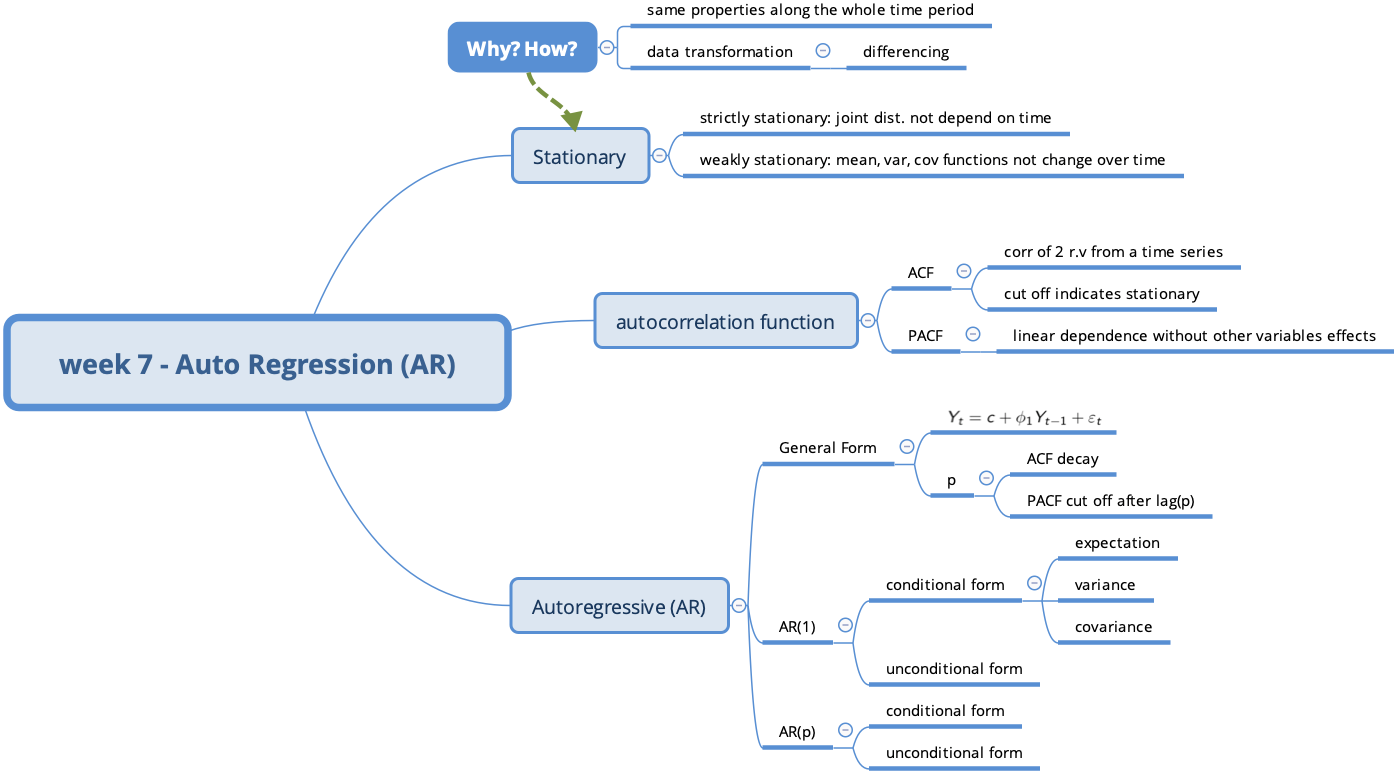

**review of tut07**
1. define a new function  
`def function(variable):
    return results`
  
  
2. group values from two variables  
`zip()`


3. Holt-winters smoothing from statsmodels  
`model = ExponentialSmoothing(y, seasonal_period, trend = 'add', seasonal = 'add/mul')`  
`model.fit()`  
`model.fittedvalues`  
`model.forecast(fc)`  

In the previous tutorials, we have learnt the basic smoothing methods for time
series data, i.e. Simple Exponential Smoothing, Holt's Linear Trend Smoothing and Holt-Winters' Smoothing model. These models have significant advantages such as <span class="girk">easy to learn and train</span> and somehow could produce reliable forecasting results by giving more significance for the recent observations.

However, there are 2 major limitations we need to address. 
- Firstly, it produces forecasts that <span class="burk">lag behind</span> the actual trend.
- Secondly, Holt-Winters' method is best used for forecasts that are <span class="burk">short-term</span> and in the absence of cyclical or residual variations.
As a result, forecasts aren't accurate when data with cyclical or residual
variations are present. As such, this kind of averaging won’t work very well.

In order to address the above issues, in Week 08 and Week 09 tutorial sessions, we will start a new topic: the Auto Regressive Integrated Moving Average (ARIMA) model, which consist 3 major components:
- The **AR part** of ARIMA indicates that the evolving variable of interest $y_t$ is <span class="mark">regressed on its own lagged</span> (i.e., prior $y_{t-1:t-p}$) values.
- The **MA part** indicates that the regression residual $\epsilon_t$ is actually a linear combination of error terms $\epsilon_{t-1:t-1}$ whose values occurred contemporaneously and at various times in the past.
- The **I (for "integrated")** indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once) so that the **ARIMA could handle the non-stationary data**. (Note that the AR, MA and ARMA model are still require a weakly stationary data as input!!!)

The purpose of each of these features is to make the model fit the data as
well as possible.

**In this week, we mainly focus on the implementation of AR model.**

Mathematically, an AR model with p-th order could be defined as:

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ...+ \phi_p y_{t-p} + \epsilon_t$$
$$y_t = c + \sum_{i=1}^p + \phi_i y_{i-1} + \epsilon_t$$
where c is a constant value, $\phi_1,… ,\phi_p$ are the parameters for the model, and $\epsilon_t$ is <span class="girk">white noise</span>.

This can be equivalent to the <span class="girk">backshift representation</span> with the operator B as:
$$y_t = c + \sum_{t = 1}^t \phi_i B^i y_t + \epsilon_t$$
so that moving the summation term to the left side and using polynomial notation, we have:
$$\epsilon = y_t - \sum_{t = 1}^t \phi_i B^i y_t - c$$
$$\epsilon = (1-\sum_{t = 1}^t \phi_i B^i)(y_t - \mu)$$
where $\mu = \frac{1}{1 - \phi_1 - ... - \phi_p}$

<br>
An AR model can thus be viewed as the output of a filter which input is white noise. (Don’t panic if you can't understand this part so far. We will talk about this in week 08 Lecture session.)

However, for an AR(p) model, some parameter constraints are necessary for the model to secure a weakly stationary. More specifically, processes in the AR(1) model with only |$\phi_1$|<1 could be viewed as **weakly stationary** (wide-sense stationary).  

**Question: 
What are the constraints for AR(2) model?**

For AR(2) model, we should have the following constraints:  |$\phi_2$| < 1, $\phi_2 + \phi_1$ <1, and $\phi_2 - \phi_1$ < 1

<br>
<br>
<br>

Selecting a suitable order value p can be tricky. We need to observe the <span class="mark">PACF curve</span> to find out the cutting off value as the order for our AR model. The partial autocorrelation of an AR(p) process equates zero at lag which is bigger than order of p and provide a good model for the correlation in $y_{1:p+1}$, so the appropriate maximum lag is the one beyond which the partial autocorrelations are all zero.

For more details of AR(p) model, please refer to the guide book:  
https://otexts.com/fpp2/AR.html  
and wiki page  
https://en.wikipedia.org/wiki/Autoregressive_model


### 1. Load and Inspect the Data
Import `pyplot`, `numpy` and `pandas`as usual. Then import the following new libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format = 'retina'

# We will use statsmodel's time series plots to draw ACF etc.
import statsmodels as sm 
import statsmodels.api as smt

# from pandas.tools.plotting import autocorrelation_plot

In [2]:
# This data is of type DataFrame with only one column
data = pd.read_csv('data.csv')
# We make it as a Series by taking out the column
data = data['Data']

Then plot the data:

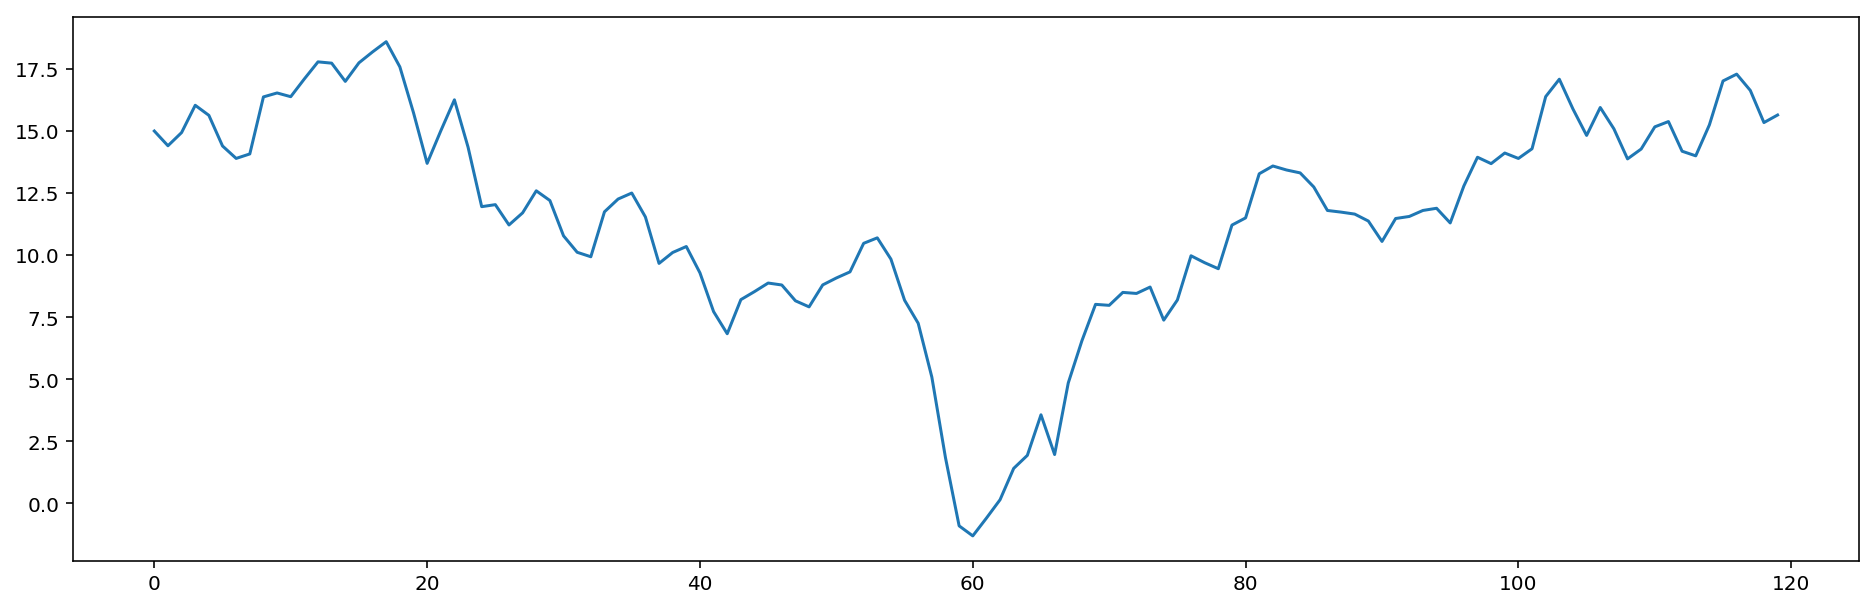

In [3]:
# Plot our data and check the correctness of import
plt.figure(figsize = (16,5))
plt.plot(data);

**Questions:**  
1. Is the time series stationary?  
2. What three rules can we use to visually check for stationarity?

In [4]:
# see step 2 and step 3

### 2.	Check if the time series is stationary

Plot the mean, variance of the data, and the covariance of the $i^{th}$ term and the $(i + k)^{th}$ term to check its stationarity.

Therefore, we must apply a transformation to make the data stationary. The simplest transformation is **differencing**. <span class="girk">Usually first or second order differencing is enough.</span>

In [5]:
# We calculate difference series, data[1]-data[0], data[2]-data[1], ...
diff_data = pd.Series.diff(data)

# Checking the first entry in diff_data
diff_data.iloc[0]

nan

**Questions:**  
Why is the first value a NaN?

In [6]:
# hint: think about the differencing formula

Let’s remove the `NaN` and plot the data

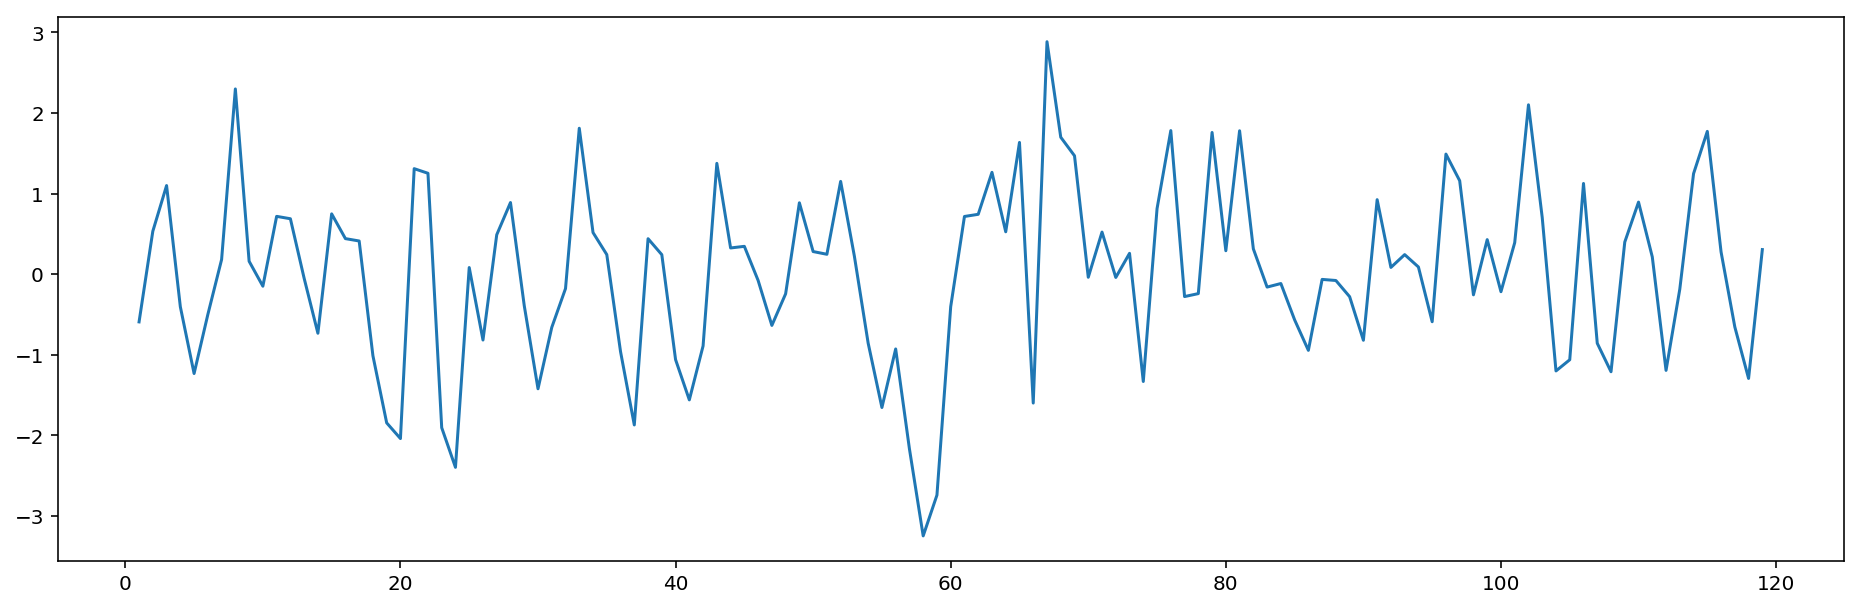

In [7]:
diff_data = diff_data.dropna()

# Plot the differenced data
plt.figure(figsize = (16,5))
plt.plot(diff_data);

Is the data now stationary?

### 3. Inspect ACF and PACF plots

ACF could be used for analyzing the stationarity. In general, it can be shown that for non-seasonal time series:

- If the <span class="girk">Sample ACF</span> of a non-seasonal time series “dies down” or “cuts off" reasonably quickly, then the time series should be considered stationary.

- If the Sample ACF of a non-seasonal time series “dies down" extremely slowly or not at all, then the time series should be considered non-stationary.

`Statsmodels` has a built-in ACF plotting function. Let’s examine the ACF and PACF plots for the original data first.

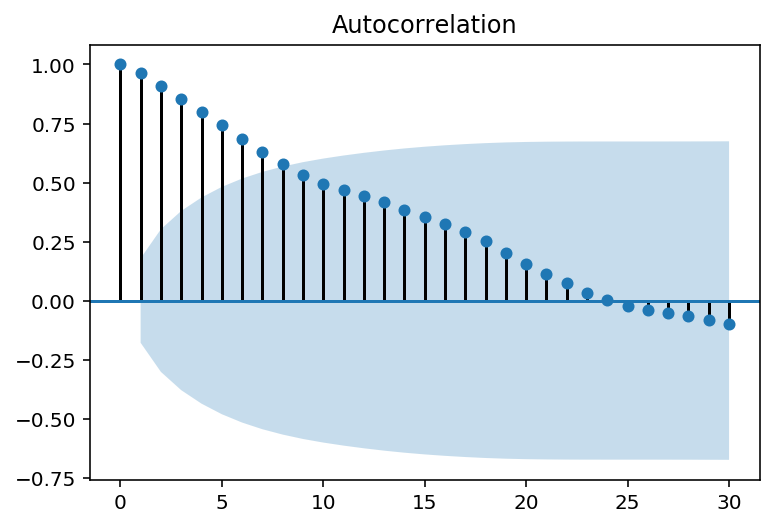

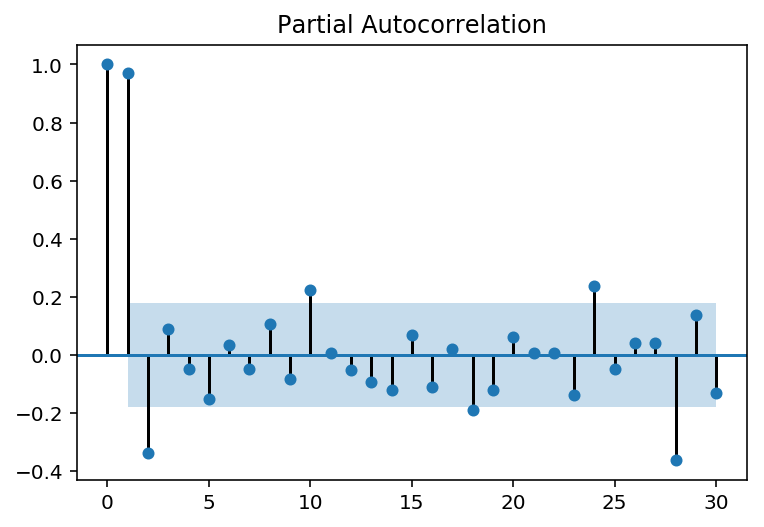

In [8]:
# original data
# Plot the ACF for the data in a new plot
smt.graphics.tsa.plot_acf(data, lags = 30, alpha = 0.05); # try diff alpha


# lags = 30 means drawing 30 lags
# alpha = .05 menas 95% confidence intervals are returned 

# Plot the PACF for the data in a new plot
smt.graphics.tsa.plot_pacf(data, lags=30, alpha=0.05)
plt.show()

Lags defines the number of time-lagging and `alpha=0.05` defines the confidence interval where the standard deviation is computer according to Bartlett's formula. You can change 0.05 to other values (i.e. 0.1) to see what happens.

Compare the original data ACF/PACF with the differenced data ACF/PACF:

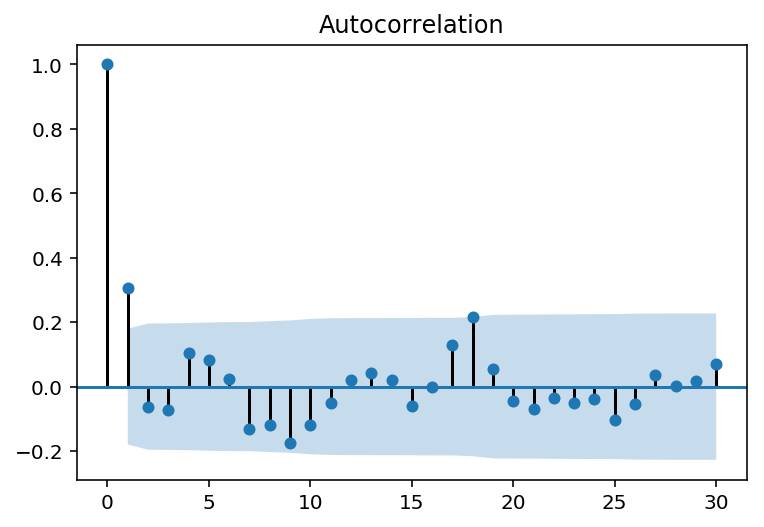

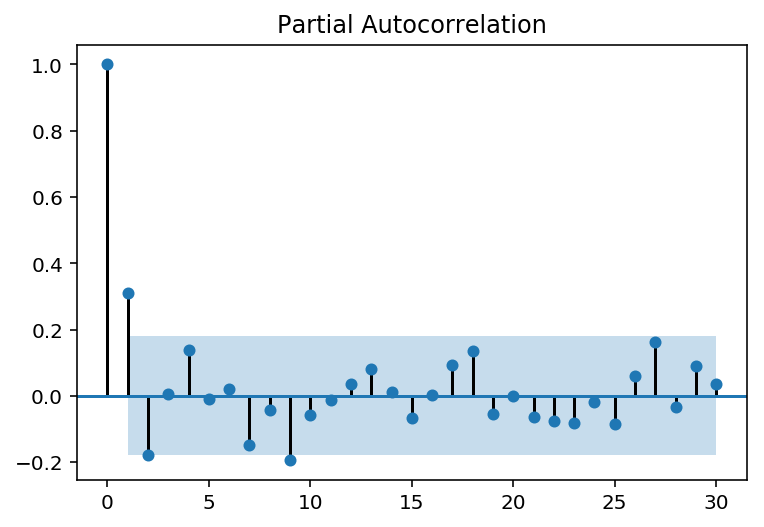

In [9]:
# For differenced time series
smt.graphics.tsa.plot_acf(diff_data, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(diff_data, lags=30, alpha = 0.05);

### 4.	Generate Samples from an AR process

`Statsmodels` provides functions to <span class="mark">generate samples from AR processes</span>. This is useful for comparison with existing data and analyzing the behavior of model parameters.

Start by setting up the parameters:

In [10]:
# use random.seed to fix the result
np.random.seed(0)

# set up required parameters
arparams = np.array([0.9]) # phi_1
zero_lag = np.array([1]) # MA

# coefficient for AR lag polynomial, including zero lag
# the AR parameters should have the opposite sign of what you might expect
ar = np.r_[1, -arparams]  # add zero-lag (coefficient 1) and negative sign

c = 0

In [11]:
# np.r_ is a quick way to create a new array
ar

array([ 1. , -0.9])

Then generate samples from a process of the form $y_t=c + 0.9 y_{t-1}+ \epsilon_t$

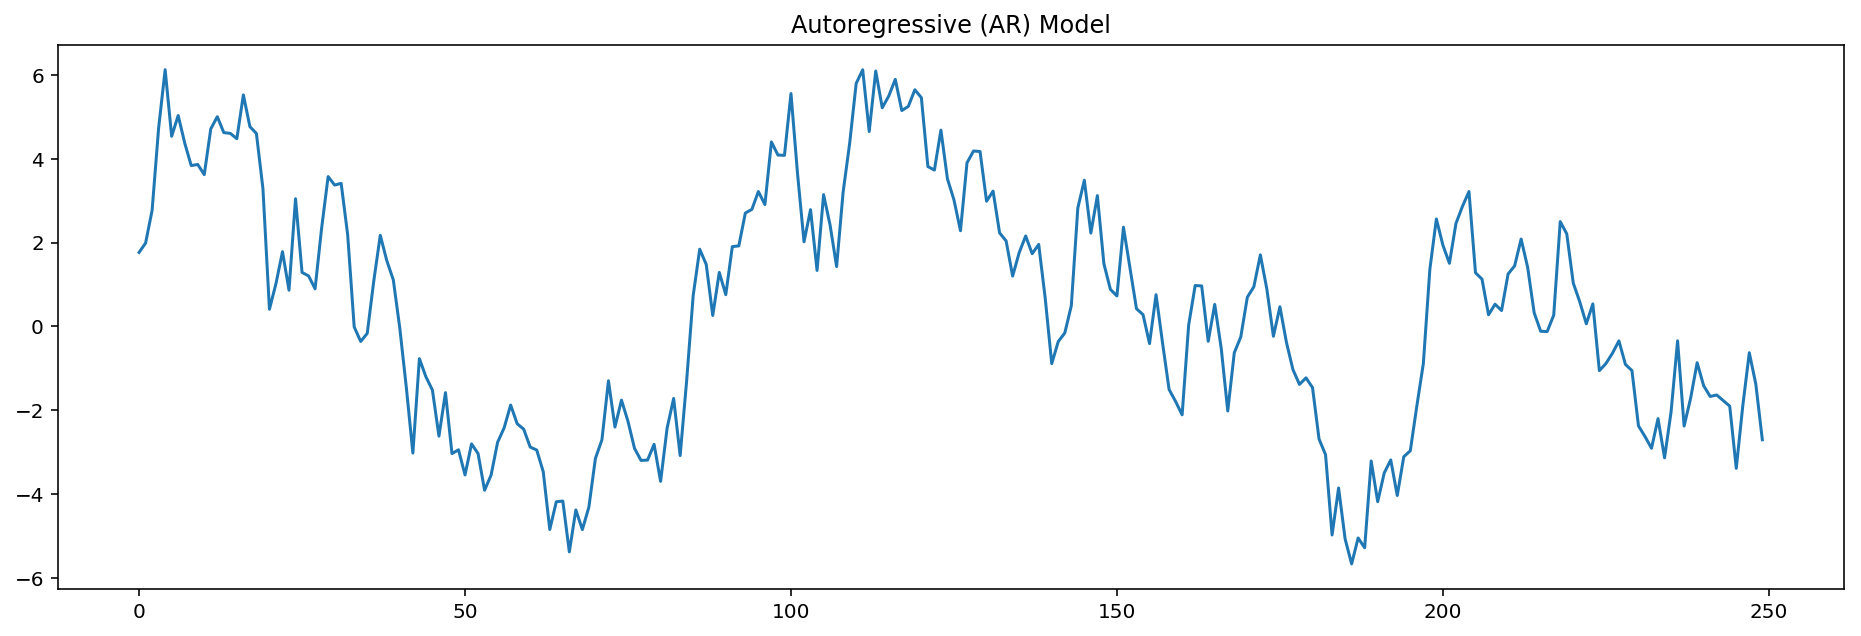

In [12]:
y1 = c + sm.tsa.arima_process.arma_generate_sample(ar = ar, 
                                                   ma = zero_lag, # for now we ignore MA term
                                                   nsample = 250) # nsample: the No. of generated sample

# Plot the times series sample
plt.figure(figsize = (16,5))
plt.plot(y1)
plt.title("Autoregressive (AR) Model");

### 5.	Inspect the ACF and PACF of the AR process

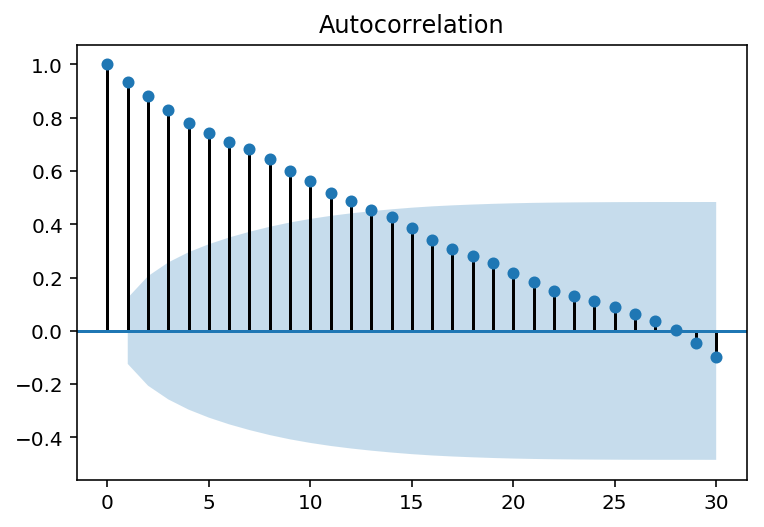

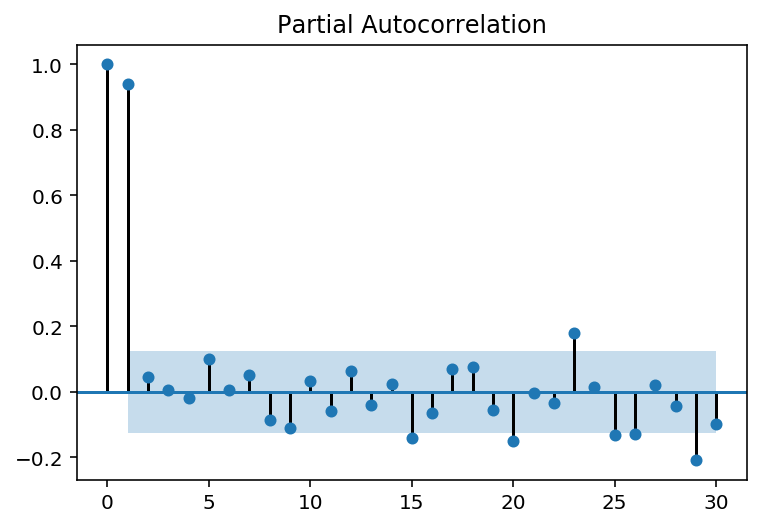

In [13]:
# Examine the ACF and PACF plots
smt.graphics.tsa.plot_acf(y1, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(y1, lags=30, alpha = 0.05);

**Questions:**
1. Check out the PACF plot, when does the plot cuts out?
2. Does the ACF plot dies down eventually?

In [14]:
# Because this is an AR(1) model, we would expect the PACF cuts off after lag 1
# and the ACF plot should dies down slowly

### 6. Calculate mean and variance of the AR process

We can use the equation below to calculate the unconditional mean of the process:
$$\mathbb{E}(y_t)=  \frac{c}{1-\phi_1}$$

In [16]:
y1_uncond_mean = c / (1 - arparams[0]) # formula
print(y1_uncond_mean)

diff_y = pd.Series.diff(pd.Series(y1)).dropna()

# check the variance from y1 and diff_y
sample_mean1 = np.mean(y1)
sample_mean2 = np.mean(diff_y)
print(sample_mean1)
print(sample_mean2)

0.0
0.4153105908697579


**Questions:**  

What is the final result of this unconditional mean?    Why are they different?

In [17]:
# since c = 1, this result will be 0 anyway.
y1_uncond_mean

0.0

To calculate the variance, use the following equation:
$$Var(y_t)=  \frac{\sigma^2}{1 - \phi_1^2}$$

`arma_generate_sample` uses `np.random.randn` to generate epsilon $\epsilon$.   Therefore we know that by default:
- $Var(\epsilon_t) = 1$ (or $\sigma^2 = 1$),  
- $\mathbb{E}(\epsilon_t) = 0$.


In [20]:
# Calculate Variance=
sigma2 = 1

y1_uncond_var = sigma2 / (1 - np.power(arparams[0],2)) # formula

# check the variance from diff_y
sample_var1 = np.var(y1)
sample_var2 = np.var(diff_y)
print(sample_var)

8.118598056082808


In [19]:
print(y1_uncond_var)

5.263157894736843
